In [1]:
import sys
import os

# 获取当前文件所在目录的绝对路径
current_dir = os.path.dirname(os.path.abspath('.'))
# 获取项目根目录
project_root = os.path.join(current_dir, '..')
# 将项目根目录添加到 sys.path
sys.path.append(project_root)


# 从根目录导入自定义库
from evals.eval4_end_to_end.utils.contract import Contract
C = Contract()

# 系统库
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter, MaxNLocator
import seaborn as sns
import random
import matplotlib.ticker as ticker

# 论文【3】中个人贡献 对 模型拥有者收益的转化是线性的！
# （即：多个用户对模型拥有者的贡献 不存在边际收益递减）
# 因此，可针对每个用户类型单独求解最优的合约项
# TODO: 该版本虽然可获取合理的合约，但是 在设计合约时没有考虑 各用户类型的比例（需要考虑吗？）\


# 随机种子设置
def set_seed(seed):
    np.random.seed(seed)  # numpy产生的随机数一致
    random.seed(seed)

set_seed(61)

ModuleNotFoundError: No module named 'cvxpy'

In [ ]:
def generate_normal_random_numbers(count, mean, std_dev):
    random_numbers = np.empty(count)
    generated_count = 0

    while generated_count < count:
        remaining_count = count - generated_count
        new_numbers = np.random.normal(loc=mean, scale=std_dev, size=remaining_count)
        valid_numbers = new_numbers[new_numbers >= 0]
        valid_count = len(valid_numbers)
        random_numbers[generated_count : generated_count + valid_count] = valid_numbers
        generated_count += valid_count

    return random_numbers

def fixed_interval_sampling(input_array, interval):
    """
    从输入数组中以固定间隔采样元素构成新的数组

    :param input_array: 输入数组
    :param interval: 采样间隔
    :return: 新的采样数组
    """
    if interval <= 0:
        raise ValueError("Interval must be greater than zero")
    
    return input_array[::interval]

In [ ]:
DEBUG = False

# 输入参数
participants_num = 100
estimated_types = np.array([0.1, 0.13, 0.16, 0.19, 0.22])
estimated_props = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

# TODO: 实际上 完全信息情况下，模型拥有者效用反而更低
participants = np.array([])
for type, prop in zip(estimated_types, estimated_props):
    tmp = generate_normal_random_numbers(int(participants_num * prop), type, 0.01)
    participants = np.concatenate((participants, tmp))
participants = np.sort(participants)
print(participants)

u_p = lambda reward, cost: reward - cost

# k1为全局准确率到模型价值的转换参数
# k2和k3为本地训练数据总量到全局模型准确率的转换参数（和训练任务有关，需要根据实际任务调整）
u_m_k = []
# u_m = lambda data, reward: u_m_k[0] * (1 - u_m_k[1] * cp.exp(-u_m_k[2] * data)) - reward
u_m = lambda data, reward: u_m_k[0] * cp.log(1 + u_m_k[1] * data) - reward

[0.07794967 0.08716089 0.08852023 0.08956385 0.09400252 0.09434772
 0.09568504 0.09874157 0.09932672 0.09958466 0.09998738 0.10203365
 0.10240179 0.10439376 0.10665573 0.10681175 0.1080677  0.11020149
 0.11029621 0.11037332 0.11061123 0.11542494 0.11619724 0.11941067
 0.12159912 0.12210951 0.12259933 0.12381362 0.12384504 0.12571866
 0.12652541 0.12910282 0.13115608 0.13126455 0.13458621 0.13501836
 0.13872918 0.1395275  0.14010157 0.14367482 0.14450724 0.14724678
 0.1473983  0.15085945 0.15112004 0.15124109 0.15211547 0.15590272
 0.15608512 0.1575062  0.15819065 0.15860641 0.15940091 0.16052987
 0.16383264 0.1649937  0.16547164 0.16802632 0.17275819 0.17414093
 0.17687911 0.17705439 0.17841987 0.17844929 0.180006   0.18000601
 0.18470307 0.19067321 0.19134771 0.19220221 0.19249158 0.19320241
 0.19335201 0.19527449 0.19569223 0.19642837 0.19690371 0.19777619
 0.19893356 0.20138548 0.20431068 0.20475111 0.20897196 0.21364483
 0.21451737 0.21609133 0.21763636 0.21824059 0.21916408 0.2194

[300, 0.001] best 2023.5901136669202 3963.473119527648
[300, 0.001] uniform 1298.246857887944 2387.5249935201896
[300, 0.001] baseline 991.3569721211009 5159.494049906024
[600, 0.001] best 23664.012344786912 14001.549119454388
[600, 0.001] uniform 22191.5022686479 10768.224940193273
[600, 0.001] baseline 19663.87106991009 18321.570270318247
[300, 0.002] best 11872.199830360492 6924.000750486073
[300, 0.002] uniform 11095.072442432556 5396.293706697788
[300, 0.002] baseline 9834.291127364953 9155.511289754397
[600, 0.002] best 54340.683805142406 16920.470105805718
[600, 0.002] uniform 52781.26893784647 13795.265510953
[600, 0.002] baseline 49287.73788199567 22330.000837011983
1 46959
2 42441
3 36723
4 35739
5 25871
6 47009


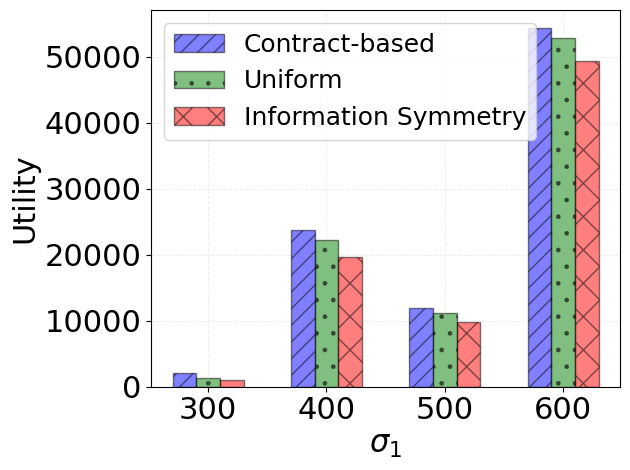

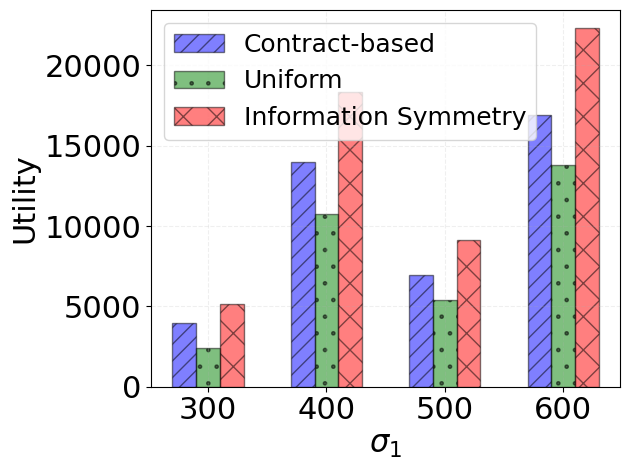

In [ ]:
# 【实验2】激励机制有效性（即优化得到的合约优于随机策略，且相对完全信息的baseline差距不大）


# method 可选：best/uniform/baseline
def run_test2(method):
    # baseline方法使用用户的实际类型来设计合约
    if method == "baseline":
        contracts = C.design_contract(participants, u_m, u_p)
    else:
        contracts = C.design_contract(estimated_types, u_m, u_p)

    if contracts:
        if DEBUG:
            print("设计的合约项:", contracts)
    else:
        print("错误：合约设计失败")
        return

    # baseline 和 best 方案 合约选择方法都用best
    selections = C.select_contract(
        participants, contracts, "uniform" if method == "uniform" else "best"
    )
    # print(method)
    # print(selections)

    if DEBUG:
        print("选择的合约项:", selections)

    (model_owner_utility, participant_utilities) = C.cal_actual_utility(selections)

    # if method != "uniform":
    #     print(method)
    #     plot_results(contracts, estimated_utilities)

    return model_owner_utility, participant_utilities


def eval2():
    def plot_grouped_bar_chart(u_m_k_list):
        schemes = ["best", "uniform", "baseline"]
        scheme_labels = ["Contract-based", "Uniform", "Information Symmetry"]
        num_tasks = len(u_m_k_list)
        num_schemes = len(schemes)

        # 获取每个任务下不同方案的效用
        owner_utilities = []
        employee_utilities = []

        sum_owner_utility = 0
        sum_employee_utility = 0
        for tmp in u_m_k_list:
            global u_m_k  # 全局变量
            u_m_k = tmp
            owner_utilities_task = []
            employee_utilities_task = []
            for scheme in schemes:
                owner_utility, employee_utility = run_test2(scheme)
                print(tmp, scheme, owner_utility, sum(employee_utility))
                owner_utilities_task.append(owner_utility)
                # print(scheme, employee_utility)
                employee_utilities_task.append(sum(employee_utility))
            owner_utilities.append(owner_utilities_task)
            employee_utilities.append(employee_utilities_task)

        # 转置列表，使其按方案分组
        owner_utilities = np.array(owner_utilities).T
        employee_utilities = np.array(employee_utilities).T

        # 设置柱状图的宽度和位置
        bar_width = 0.2
        indices = np.arange(num_tasks)

        # 柱状图参数
        hatchs = ["//", ".", "x"]
        colors = ["b", "g", "r"]

        # 绘制模型拥有者效用的柱状图
        fig1, ax1 = plt.subplots()
        for i in range(num_schemes):
            ax1.bar(
                indices + i * bar_width,
                owner_utilities[i],
                bar_width,
                label=scheme_labels[i],
                hatch=hatchs[i],
                edgecolor="k",
                alpha=0.5,
                color=colors[i],
            )
        ax1.set_xlabel(r"$\sigma_1$", fontsize=22)
        ax1.set_ylabel("Utility", fontsize=22)
        ax1.set_xticks(indices + bar_width)
        ax1.set_xticklabels([300, 400, 500, 600])
        # 设置刻度字体大小
        ax1.tick_params(axis="x", labelsize=22)
        ax1.tick_params(axis="y", labelsize=22)
        ax1.legend(loc="upper left", fontsize=18)
        ax1.grid(ls="--", alpha=0.2)

        # 保存并显示模型拥有者效用的柱状图
        plt.tight_layout()
        plt.savefig(f"outputs/utility_owner.pdf", dpi=300, bbox_inches="tight")

        # 绘制雇员总效用的柱状图
        fig2, ax2 = plt.subplots()
        for i in range(num_schemes):
            ax2.bar(
                indices + i * bar_width,
                employee_utilities[i],
                bar_width,
                label=scheme_labels[i],
                hatch=hatchs[i],
                edgecolor="k",
                alpha=0.5,
                color=colors[i],
            )
        ax2.set_xlabel(r"$\sigma_1$", fontsize=22)
        ax2.set_ylabel("Utility", fontsize=22)
        ax2.set_xticks(indices + bar_width)
        ax2.set_xticklabels([300, 400, 500, 600])
        ax2.tick_params(axis="x", labelsize=22)
        ax2.tick_params(axis="y", labelsize=22)
        ax2.legend(loc="upper left", fontsize=18)
        ax2.grid(ls="--", alpha=0.2)

        # 保存并显示雇员总效用的柱状图
        plt.tight_layout()
        plt.savefig(f"outputs/utility_worker.pdf", dpi=300, bbox_inches="tight")

    # k1为全局准确率到模型价值的转换参数
    # k2为本地训练数据总量到全局模型准确率的转换参数（和训练任务有关，需要根据实际任务调整）
    # 这里可以对多种实际任务进行测试，得到相应参数（后续端到端实验，可仅选其中两个代表性的任务）
    u_m_k_list = [
        # [225, 0.001],
        [300, 0.001],
        [600, 0.001],
        [300, 0.002],
        [600, 0.002],
    ]

    plot_grouped_bar_chart(u_m_k_list)


# 【解释】（需要仔细查看内部数据 来进行解释！）
# 为什么雇员的效用，best方案可以高于baseline？
# 因为不精确的合约设计，可能导致雇员xxx，从而获取过多的收益
# 而uniform方案，因为xxx，有时候会导致雇员的效益特别低
eval2()

# owner_utility best
print(1, 2023 + 6803 + 14469 + 23664)

# owner_utility uniform
print(2, 1298 + 5908 + 13044 + 22191)

# owner_utility baseline
print(3, 991 + 4808 + 11261 + 19663)

# worker_utility best
print(4, 3963 + 7387 + 10388 + 14001)

# worker_utility uniform
print(5, 2387 + 5152 + 7564 + 10768)

# worker_utility baseline
print(6, 5159 + 9599 + 13930 + 18321)

In [ ]:
def plot_results(contracts, estimated_utilities):
    SIZE1 = 22
    SIZE2 = 18

    # A 折线图
    fig, ax1 = plt.subplots(figsize=(7,4.8))

    contract_nums = range(1, len(contracts) + 1)
    gradient_quality = [contract[0] for contract in contracts]
    rewards = [contract[1] for contract in contracts]

    ax1.set_xlabel(r"Worker Type $m$" , fontsize=SIZE1)
    ax1.set_ylabel(r"Data Size $D$", color="tab:blue", fontsize=SIZE1)
    ax1.plot(
        contract_nums,
        gradient_quality,
        "o-",
        color="tab:blue",
        label="Data Size",
    )
    ax1.set_xticks([1, 2, 3, 4, 5])
    ax1.tick_params(axis="y", labelcolor="tab:blue", labelsize=SIZE1)
    ax1.tick_params(axis="x", labelsize=SIZE1)
    plt.grid(ls="--", alpha=0.2)

    ax2 = ax1.twinx()
    ax2.set_ylabel(r"Rewards $R$", color="tab:red", fontsize=SIZE1)
    ax2.plot(contract_nums, rewards, "v--", color="tab:red", label="Rewards")
    ax2.tick_params(axis="y", labelcolor="tab:red", labelsize=SIZE1)
    ax2.tick_params(axis="x", labelsize=SIZE1)

    fig.tight_layout()
    fig.legend(loc="upper left", bbox_to_anchor=(0.19, 0.96), fontsize=SIZE2)
    plt.savefig(f"outputs/eval_monotonicity.pdf", dpi=300, bbox_inches="tight")

    # B 折线图
    plt.figure()
    for eta, utilities in estimated_utilities.items():
        plt.plot(contract_nums, utilities, "o-", label=r"$\varphi_m$ = " + f"{eta}")
    plt.xlabel("Contracts", fontsize=SIZE1)
    plt.ylabel("Utility", fontsize=SIZE1)
    plt.yticks(fontsize=SIZE1)
    plt.xticks(fontsize=SIZE1)
    # 设置x轴刻度仅显示整数
    ax = plt.gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend(fontsize=SIZE2)
    plt.grid(ls="--", alpha=0.2)
    plt.savefig(f"outputs/eval_ICIR.pdf", dpi=300, bbox_inches="tight")

best
设计的合约项: [(array(391.99999884), 86.23999974425531), (array(538.99999955), 114.16999987893385), (array(897.99999547), 171.60999922663638), (array(1263.99999825), 219.18999958755836), (array(2025.99999155), 295.38999891811613)]
选择的合约项: [(0.07794967086908838, (array(2025.99999155), 295.38999891811613)), (0.0871608891173282, (array(2025.99999155), 295.38999891811613)), (0.08852022670779575, (array(2025.99999155), 295.38999891811613)), (0.08956384775881755, (array(2025.99999155), 295.38999891811613)), (0.09400251777735487, (array(2025.99999155), 295.38999891811613)), (0.09434772431610686, (array(2025.99999155), 295.38999891811613)), (0.09568504448440189, (array(2025.99999155), 295.38999891811613)), (0.09874157044046347, (array(2025.99999155), 295.38999891811613)), (0.09932671560211165, (array(2025.99999155), 295.38999891811613)), (0.09958466106794292, (array(2025.99999155), 295.38999891811613)), (0.09998738181162248, (array(2025.99999155), 295.38999891811613)), (0.10203364783003484, (ar

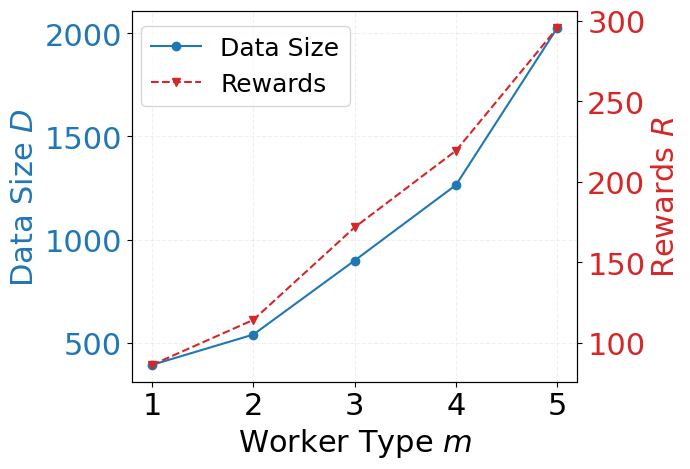

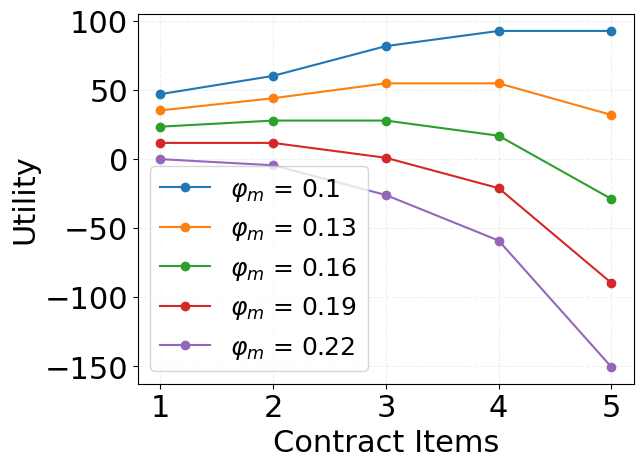

In [ ]:
# 【实验1】激励机制正确性（优化得到的合约满足IR和IC）
# TODO：该实验仅测一组参数是否合理？考虑测两组（即后续实验使用的两个典型任务）？


# method 可选：best/uniform/baseline
def run_test1(method):
    # baseline方法使用用户的实际类型来设计合约
    if method == "baseline":
        contracts = C.design_contract(participants, u_m, u_p)
    else:
        contracts = C.design_contract(estimated_types, u_m, u_p)

    if contracts:
        print("设计的合约项:", contracts)
    else:
        print("错误：合约设计失败")
        return

    # baseline 和 best 方案 合约选择方法都用best
    selections = C.select_contract(
        participants, contracts, "uniform" if method == "uniform" else "best"
    )
    print("选择的合约项:", selections)

    # 模拟攻击者有[attacker_rate]概率骗过雇主，不付出任何贡献就能拿到合约奖励
    # 因此模型拥有者拿到的贡献减少了
    (
        _,
        _,
        estimated_utilities,
    ) = C.evaluate_effect(selections, estimated_types, contracts)

    if DEBUG:
        print("每个类型选择各合约项时的效用:")
        for eta, utilities in estimated_utilities.items():
            print(f"类型 {eta}: {utilities}")
    plot_results(contracts, estimated_utilities)


def eval1():
    global u_m_k
    # 设定实验参数
    u_m_k = [300, 0.001]

    # 【实验1.2图】参与者选取能使自己净收益最高的合约项
    print("best")
    run_test1("best")

    # 参与者选取为最高成本类型设置的合约项
    # print("uniform")
    # run_test1("uniform")

    # 完全信息场景（基于实际的用户类别设计合约 + 参与者选取最优合约项）
    # print("baseline")
    # run_test1("baseline")

    # 存在攻击（模拟攻击者有小概率骗过雇主，不付出任何贡献就能拿到合约奖励）
    # 该模拟 没有考虑 攻击者恶意提交导致 模型性能下降，降低模型拥有者的效用（如果考虑了 模型拥有者的效用更低）
    # 思考如何放在intro里
    # run_test1("attack", 0.1)


eval1()

In [ ]:
# 【实验3】攻击者对激励机制效果的影响（作为论文的准备知识）
# 对于两个典型任务，展示攻击成功率在0到1时，模型拥有者【和雇员？】的效用

# 若攻击者已知自己的攻击成功率。考虑 它们可选取收益更高的合约项 以获取更高的收益？
# 原始：雇员根据自己的单位成本，选取使自己净收益最大化的合约

# 攻击：雇员有小概率欺骗雇主，使用较低的成本即可通过合约项的验证；
# 这会导致：
# 1.雇主支付奖励购买了低质量的贡献，降低了雇主的效用
# 2.雇员由于成本降低，提高了获得的收益，甚至可以选取超过自己能力的合约项来获取更多收益

# 新的模拟方式：
# 【所有】雇员按实际成本选取合约项；但在计算【恶意】雇员效用时，将获取的奖励乗【攻击成功率】比例，且成本为0（模拟一种极端情况？）
# 雇主在计算效用时，将所有【恶意】雇员的贡献项设为0（无论攻击是否成功）
# （乐观假设攻击成功的提交虽然无贡献，但也不会额外降低模型性能；实际情况雇主效用可能更低）


def run_test3(attack_ratio, attack_succ_rate):
    # 雇主设计合约
    contracts = C.design_contract(estimated_types, u_m, u_p)

    if contracts:
        if DEBUG:
            print("设计的合约项:", contracts)
    else:
        print("错误：合约设计失败")
        return

    # 雇员选择合约项
    selections = C.select_contract(participants, contracts, "best")

    if DEBUG:
        print("选择的合约项:", selections)

    return C.evaluate_effect_with_attacker(selections, attack_ratio, attack_succ_rate)


# 返回值 恶意参与者效用、诚实参与者效用、模型拥有者效用
# 结果1：攻击者效用随攻击成功率提升而提升，在攻击成功率较低时 甚至可能低于诚实参与者
# 结果2：诚实参与者的效用不受攻击者比例影响
# 结果3：模型拥有者效用随着攻击强度增加而降低

# 展示方式：
# 满足诚实大多数，在不同攻击强度下，雇主和雇员的效用
# 雇员 固定攻击成功率（如10%），用攻击者比例（例如1%-49%）作为攻击强度

attack_succ_rate = 0.05
for attack_ratio in np.arange(0, 0.5, 0.05):
    print(run_test3(attack_ratio, attack_succ_rate))   

AttributeError: 'Contract' object has no attribute 'evaluate_effect_with_attacker'